#  Convolutional Neural Networks (CNN) with pytorch

---



## Objective of this lab session: perform classification on MNIST using convolutional neural networks

 MNIST classification has been performed relying on Multi-Layer Perceptron (MLP) models. The obtained accuracy was 92% with a softmax regressor and 97% (or 98%) with a deeper MLP. This can be further improved! Let us jump from such simple models to something moderately more sophisticated, namely **Convolutional Neural Networks** (CNN).

For recall, **MNIST** is a computer vision dataset which consists of handwritten digit images with associated label. Each image in MNIST has a corresponding label - a number between 0 and 9 - representing the digit drawn in the image.

### 1- Data management

Start with these lines of code to automatically download the MNIST dataset.

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

Failed to download (trying next):
<urlopen error [Errno 11001] getaddrinfo failed>



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [6]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
  num_train = len(train_data)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_index, valid_index = indices[split:], indices[:split]

  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(valid_index)

  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
      
  return train_loader, valid_loader, test_loader

In [7]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

Let us visualize some images from the training set with corresponding ground truth labels.

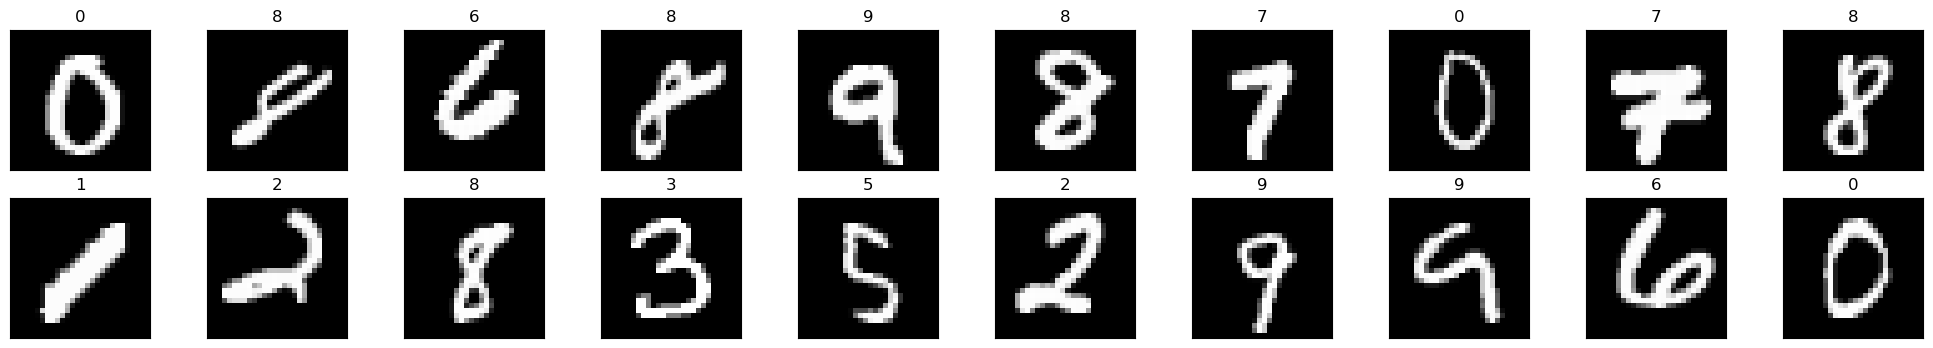

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader) 
images, labels = next(data_iter) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

### 2- Simple CNN architecture

Let us define a simple **CNN architecture**. The network will take as inputs 28x28 images instead of 784-dimensional tensors of pixel values as for MLP models.  A CNN architecture is a stack of layers including:
  - convolutional layer using *nn.Conv2D* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
  - max-pooling layer using *nn.MaxPool2D* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
  - regular densely-connected layer using *nn.Linear* ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):  

    def __init__(self):
        super(Net1,self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(4, 4, 3, stride=1)
        self.max_pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(4*12*12, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x= self.max_pool(x)
        x = x.view(-1, 4*12*12)
        out= self.fc(x)
        return out

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


**torchsummary** provides information complementary to what is provided by *print(your_model)* in PyTorch, similar to the Tensorflow *model.summary()* routine ([documentation](https://pypi.org/project/torch-summary/)). This can be helpful while debugging your network!

In [11]:

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

Net1(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)

In [13]:
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

### 3- Training


In [14]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0 # monitor losses
      
      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad() # clear the gradients of all optimized variables
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
          loss = criterion(output, label) # calculate the loss
          loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step() # perform a single optimization step (parameter update)
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
            output = model(data)
          loss = criterion(output,label) 
          valid_loss += loss.item() * data.size(0)
      
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [15]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.691122 	validation Loss: 0.316187
validation loss decreased (inf --> 0.316187).  Saving model ...
epoch: 2 	training Loss: 0.267374 	validation Loss: 0.236077
validation loss decreased (0.316187 --> 0.236077).  Saving model ...
epoch: 3 	training Loss: 0.201647 	validation Loss: 0.165585
validation loss decreased (0.236077 --> 0.165585).  Saving model ...
epoch: 4 	training Loss: 0.158195 	validation Loss: 0.140743
validation loss decreased (0.165585 --> 0.140743).  Saving model ...
epoch: 5 	training Loss: 0.127874 	validation Loss: 0.116771
validation loss decreased (0.140743 --> 0.116771).  Saving model ...
epoch: 6 	training Loss: 0.111246 	validation Loss: 0.125158
epoch: 7 	training Loss: 0.100641 	validation Loss: 0.101602
validation loss decreased (0.116771 --> 0.101602).  Saving model ...
epoch: 8 	training Loss: 0.093958 	validation Loss: 0.093216
validation loss decreased (0.101602 --> 0.093216).  Saving model ...
epoch: 9 	training Loss: 0.089000 

To study the **convergence** of the training process, we plot the evolution of the loss function for training and validation sets with respect to epochs.

Text(0, 0.5, 'loss value')

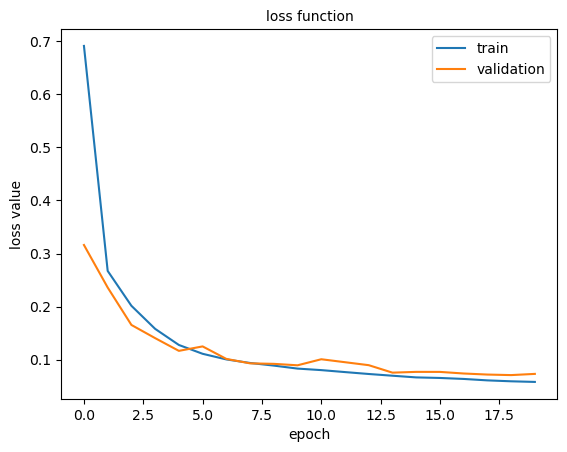

In [16]:
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

Let us load the model corresponding to the lowest validation loss.

In [17]:
cnn_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

### 4- Testing


In [18]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)
    
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %1s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [19]:
evaluation(cnn_1, test_loader, criterion) 

test Loss: 0.064263

test accuracy of 0: 99% (975/980)
test accuracy of 1: 98% (1121/1135)
test accuracy of 2: 97% (1003/1032)
test accuracy of 3: 98% (996/1010)
test accuracy of 4: 97% (959/982)
test accuracy of 5: 97% (872/892)
test accuracy of 6: 98% (944/958)
test accuracy of 7: 98% (1009/1028)
test accuracy of 8: 96% (938/974)
test accuracy of 9: 97% (979/1009)

test accuracy (overall): 97.96% (9796/10000)


### 5- Assessment

The following cell displays test images and their labels in this format: predicted (ground-truth). The text will be green for accurately classified examples and red for incorrect predictions.

In [24]:
def visualization(model, test_loader):

  data_iter = iter(test_loader)
  images, labels = next(data_iter) # obtain one batch of test images
  images = images.to(device=device, dtype=torch.float32)
  labels = labels.to(device=device, dtype=torch.long)
  with torch.no_grad():
      output = model(images) # get model output
  _, preds = torch.max(output, 1) # convert output probabilities to predicted class
  images = images.cpu().numpy() # prep images for display
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

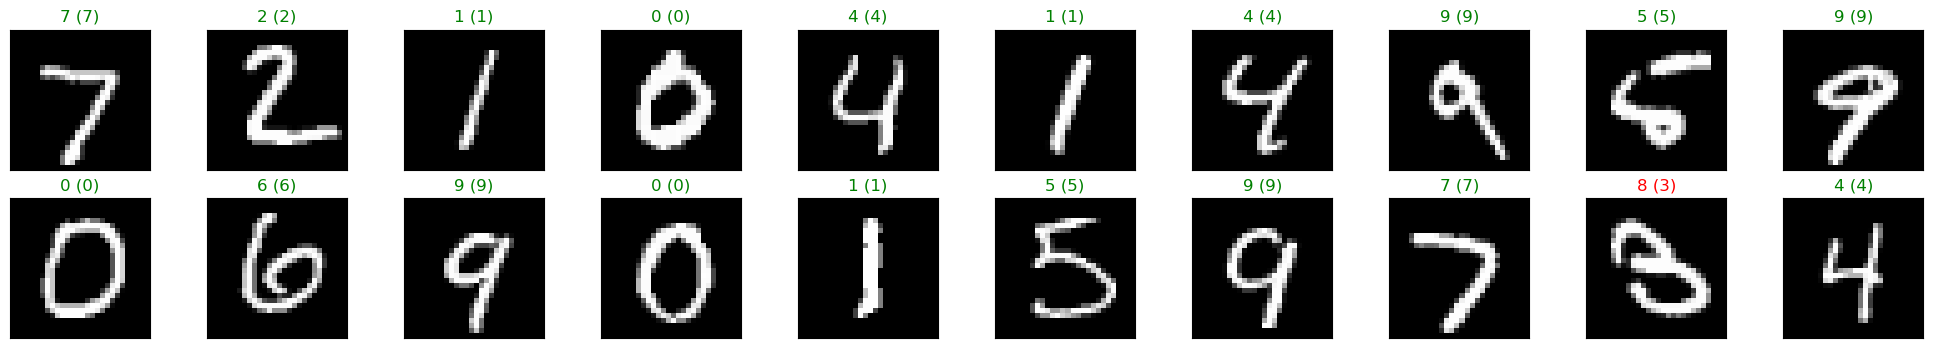

In [25]:
visualization(cnn_1, test_loader)

Let us extract predicted (*preds*) and ground truth (*targets*) labels for images arising from the test set.

In [26]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [27]:
targets, preds_1 = get_all_prediction(cnn_1, test_loader)

In [28]:
from sklearn.metrics import confusion_matrix
import itertools

class_names= ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix


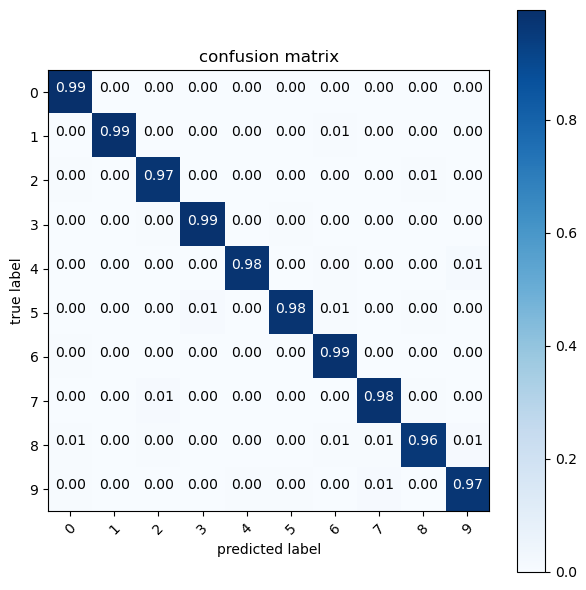

In [29]:
# compute confusion matrix
cnf_matrix = confusion_matrix(targets, preds_1)
np.set_printoptions(precision=2)


# plot normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix', cmap=plt.cm.Blues)

plt.show()